### Collaboration's notice


1. Improvements compared with V0.1:
   - Break the function ``egm_factory`` into two functions ``optimal_c`` and ``K``.
   - Convert it into ``MyST-md`` format by ``jupytext``.
   - Adjust the coefficient of $P$ and $\sigma$_vec and $\mu$-vec.
   - Converging time is **much shorter**.
   - Add assumption testings.
   - Change the loop structure.

2. Fault:
   - The assumption testing is still not on the money.

3. Solution:
   - Simulate the AR(1) Z and refer to section 4 &5 in John & Qingyin's paper.

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64
from quantecon.optimize.root_finding import brentq

%matplotlib inline

In [160]:
ifp_data = [
    ('γ', float64),              # Utility parameter 
    ('P', float64[:, :]),        # Transition probs for z_t
    ('σ_vec', float64[:]),       # Shock scale parameters for R_t, β_t, Y
    ('μ_vec', float64[:]),       
    ('a_grid', float64[:]),      # Grid over asset values (array)
    ('s_grid', float64[:]),
    ('ε_draws', float64[:]),
    ('η_draws', float64[:]),     # Draws of innovation η for MC (array)
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC (array)
]

In [161]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation 
    problem. 
    """
    def __init__(self,
                 γ=2.5,                        
                 P=np.array([(0.8, 0.2), 
                             (0.7, 0.3)]),
                 σ_vec=np.array((0.0, -3.25)),
                 μ_vec=np.array((0.0, 0.03)),
                 shock_draw_size=400,
                 grid_max=10,
                 grid_size=20):
        
        np.random.seed(1234)  # arbitrary seed

        self.γ = γ
        self.P, self.σ_vec, self.μ_vec = P, σ_vec, μ_vec
        self.ε_draws = np.random.randn(shock_draw_size)
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.a_grid = np.linspace(0, grid_max, grid_size)
        self.s_grid = np.copy(self.a_grid)
        
    # Marginal utility    
    def u_prime(self, c):
        return c ** (-self.γ)
    
    # Inverse utility
    def u_prime_inv(self, du):
        return du ** (-1 / self.γ)
    
    def β(self, z, ε):
        return np.exp(self.σ_vec[z] * ε + self.μ_vec[z])
    
    def R(self, z, ζ):
        return np.exp(self.σ_vec[z] * ζ + self.μ_vec[z])
    
    def Y(self, z, η):
        return np.exp(self.σ_vec[z] * η + self.μ_vec[z])

In [162]:
ifp = IFP()

## Testing the assumptions

In [163]:
@njit
def growth_condition_beta(ifp):
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    n = len(ε_draws)
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    β_prod = np.ones(n)
    for z_hat in (0, 1):
        for t in range(n):
            β_prod[t+1] = β(z_hat, ε_draws[t+1]) * β_prod[t]
    return β_prod[n] ** (1/n) 

In [164]:
growth_condition_beta(ifp)

nan

In [165]:
@njit
def growth_condition_betaR(ifp):
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    n = len(ε_draws)
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    βR_prod = np.ones(n)
    for z_hat in (0, 1):
        for t in range(n):
            βR_prod[t+1] = β(z_hat, ε_draws[t+1]) * R(z_hat, ζ_draws[t+1]) * βR_prod[t]
    return βR_prod[n] ** (1/n) 

In [166]:
growth_condition_betaR(ifp)

nan

## Implement the endogenous grid method

In [167]:
@jit(nopython=True)
def optimal_c(s, z, σ_vec, ifp):
    
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    n = len(ε_draws)
    
    c = lambda a, z: interp(a_grid, σ_vec[:, z], a)
        
    Ez = 0.0
    for z_hat in (0, 1):
        for i in range(n):
            β_hat = β(z_hat, ε_draws[i])
            R_hat = R(z_hat, ζ_draws[i])
            Y_hat = Y(z_hat, η_draws[i])
            Ez += β_hat * R_hat * u_prime(c(R_hat * s + Y_hat, z_hat)) * P[z, z_hat]
                
    Ez = Ez / (n ** 3)
    return u_prime_inv(Ez)
    

In [168]:
@jit(nopython=True)
def K(c, ifp):
    
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    
    c_new = np.empty_like(c)
    for z in (0, 1):
        for i in range(len(s_grid)):
            s = s_grid[i]
            
            c_new[i, z] = optimal_c(s, z, c, ifp)
            
        a_new = c_new[:, z] + s_grid
        c_new[:, z] = interp(a_new, c_new[:, z], a_grid)
        
        c_new[:, z] = np.minimum(c_new[:, z], a_grid)
        
    return c_new

In [169]:
def solve_model(ifp,
                K,
                tol=1e-3,
                max_iter=1e3,
                verbose=True,
                print_skip=4):

    """
    Solves for the optimal policy using operator K

    * ifp is an instance of ConsumerProblem
    * K is an operator that updates consumption policy
    """

    # Initial guess of c_vec = consume all assets
    n = len(ifp.a_grid)
    c = np.empty((n, 2))
    for z in 0, 1:
        c[:, z] = ifp.a_grid

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        c_new = K(c, ifp)

        error = np.max(np.abs(c - c_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        c[:, :] = c_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return c

In [170]:
%%time
c = solve_model(ifp, K)

Error at iteration 4 is 0.5152792798532912.
Error at iteration 8 is 0.4552502173748936.
Error at iteration 12 is 0.3499516125596971.
Error at iteration 16 is 0.26927172438978886.
Error at iteration 20 is 0.20731575895326904.
Error at iteration 24 is 0.15965651527485525.
Error at iteration 28 is 0.12296700178722997.
Error at iteration 32 is 0.09471367279300935.
Error at iteration 36 is 0.07295373147641637.
Error at iteration 40 is 0.056193751252571755.
Error at iteration 44 is 0.04328439887895108.
Error at iteration 48 is 0.03334084308077406.
Error at iteration 52 is 0.025681633704757678.
Error at iteration 56 is 0.01978195225350937.
Error at iteration 60 is 0.015237577404412506.
Error at iteration 64 is 0.011737156055044246.
Error at iteration 68 is 0.00904086435052584.
Error at iteration 72 is 0.006963973503481227.
Error at iteration 76 is 0.005364192136911944.
Error at iteration 80 is 0.004131916934025141.
Error at iteration 84 is 0.0031827231962576613.
Error at iteration 88 is 0.002

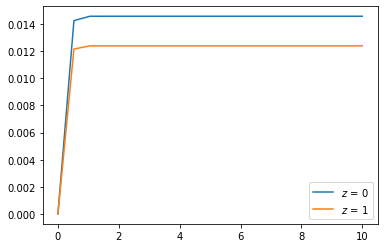

In [171]:
for z in [0, 1]:
    plt.plot(ifp.a_grid, c[:, z], label=f"$z$ = {z}")

plt.legend()
plt.show()